# An RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour patterns you are trying to predict.

<div class="alert alert-block alert-warning">
This is the solution file. The corresponding tutorial file is [01_RNN_generator_playground.ipynb](01_RNN_generator_playground.ipynb)
</div>

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


## Load temperatures (Seattle, university of WA campus)

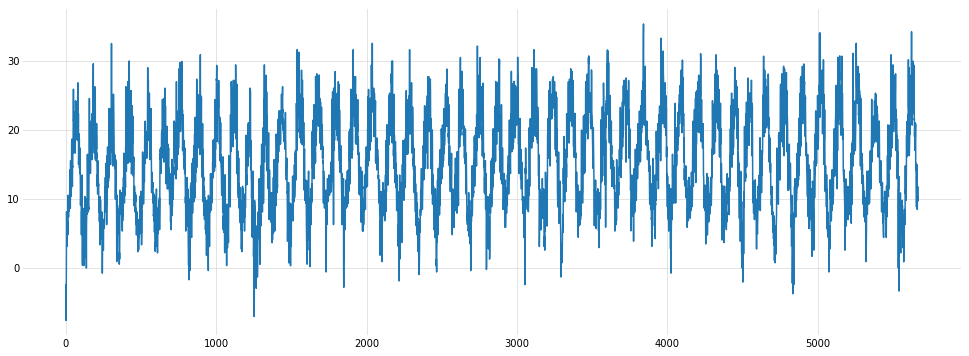

[-2.43333333 -7.6        -5.         ... 11.66666667 17.56666667
 14.1       ]
['1909-01-04' '1909-01-05' '1909-01-06' ... '1914-09-03' '1914-09-04'
 '1914-09-05']


In [12]:
temperatures = np.genfromtxt(open("temperatures/univ_of_wa_temperatures.csv", "rb"), delimiter=",", skip_header=True,
                      usecols=[1,2,3], converters = {1: lambda s: np.datetime64(s)})
dates = temperatures[:]['f0']
min_temps = temperatures[:]['f1']
max_temps = temperatures[:]['f2']

DATA_SEQ_LEN = max_temps.shape[0]
data = np.nan_to_num(max_temps[0:17010]) ## Hack, must clean the data properly. Also, skipping dates !!
data = np.reshape(data, [-1, 5])
data = np.mean(data, axis=1)
#plt.plot(dates[0:700], data[0:700])
plt.plot(data)
plt.show()
print(data[0:2000])
print(dates[0:2000])

## Hyperparameters

In [3]:
RNN_CELLSIZE = 100  # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 64         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)

## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (32, 64)
Label shape: (32, 64)
Excerpt from first batch:


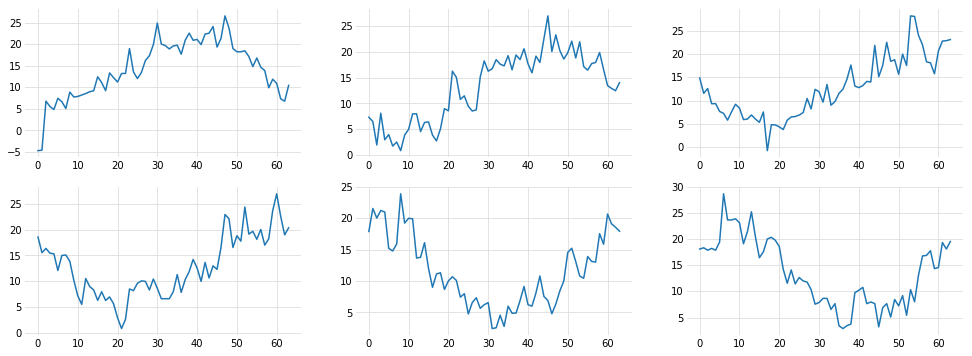

In [4]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for samples, labels, epoch in utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("Excerpt from first batch:")
subplot = 231
for i in range(6):
    plt.subplot(subplot)
    plt.plot(samples[i])
    subplot += 1
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [5]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE, activation=tf.nn.tanh) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin, dtype=tf.float32)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op, Yr

## Instantiate the model

In [6]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op, Yr = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [7]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [8]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

epoch 0, batch 0, loss=256.7796


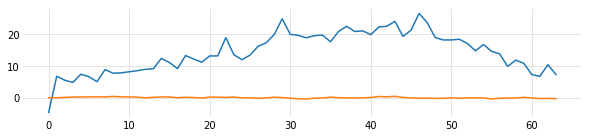

epoch 30, batch 30, loss=9.840545
epoch 60, batch 60, loss=7.8286567
epoch 90, batch 90, loss=7.3757234


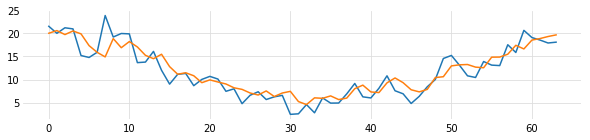

epoch 120, batch 120, loss=7.5275884
epoch 150, batch 150, loss=7.5909233
epoch 180, batch 180, loss=7.1137967


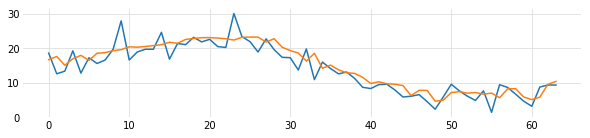

epoch 210, batch 210, loss=6.9367485
epoch 240, batch 240, loss=6.656253
epoch 270, batch 270, loss=6.619446
epoch 300, batch 300, loss=6.0075417


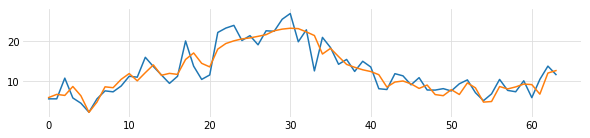

epoch 330, batch 330, loss=6.4128475
epoch 360, batch 360, loss=5.755992
epoch 390, batch 390, loss=5.835022


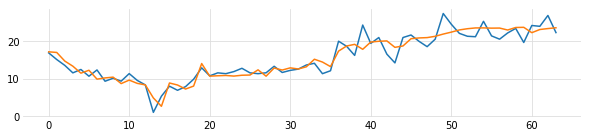

epoch 420, batch 420, loss=5.869597
epoch 450, batch 450, loss=5.057535
epoch 480, batch 480, loss=4.896097


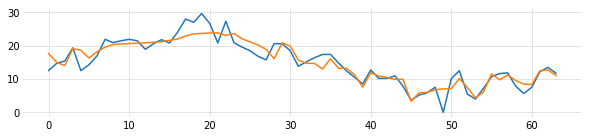

epoch 510, batch 510, loss=4.777115
epoch 540, batch 540, loss=4.363562
epoch 570, batch 570, loss=4.1356206
epoch 600, batch 600, loss=4.310314


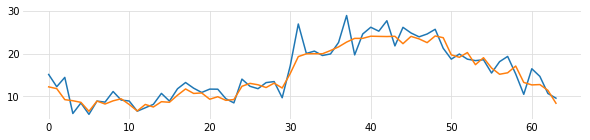

epoch 630, batch 630, loss=3.791623
epoch 660, batch 660, loss=3.4134693
epoch 690, batch 690, loss=3.199295


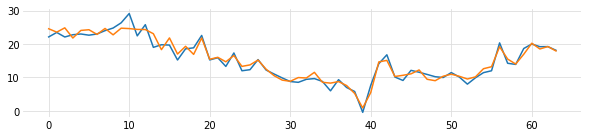

epoch 720, batch 720, loss=2.8535867
epoch 750, batch 750, loss=2.8513565
epoch 780, batch 780, loss=2.5676007


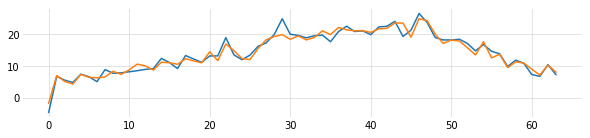

epoch 810, batch 810, loss=2.3107944
epoch 840, batch 840, loss=2.012899
epoch 870, batch 870, loss=2.0071301
epoch 900, batch 900, loss=1.8575928


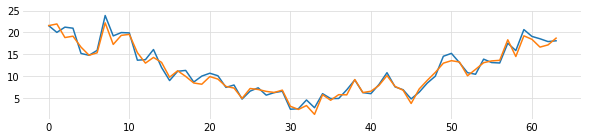

epoch 930, batch 930, loss=1.62482
epoch 960, batch 960, loss=1.4654589
epoch 990, batch 990, loss=1.3252727


In [9]:
NB_EPOCHS = 1000

H_ = Hzero
losses = []
indices = []
for i, (next_samples, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_samples = np.expand_dims(next_samples, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _, Yr_ = sess.run([Yout, H, loss, train_op, Yr], feed_dict=feed)
    # print progress
    if i%30 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
    if i%100 == 0:
        plt.figure(figsize=(10,2))
        plt.plot(next_labels[0,:,0])
        plt.plot(Yr_[0,:,0])
        plt.show()

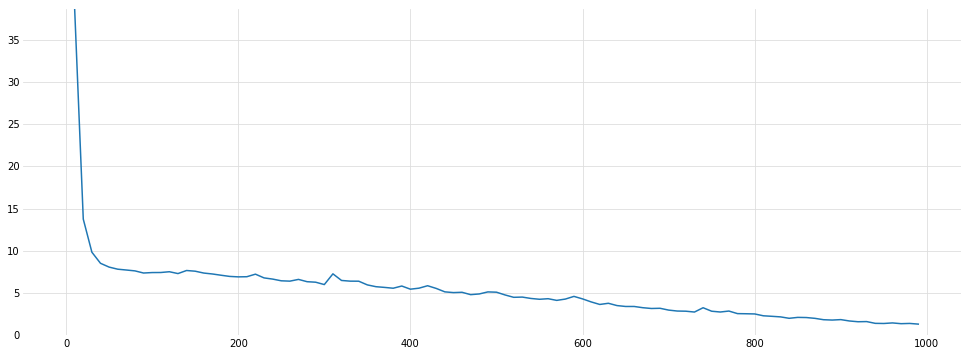

In [10]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

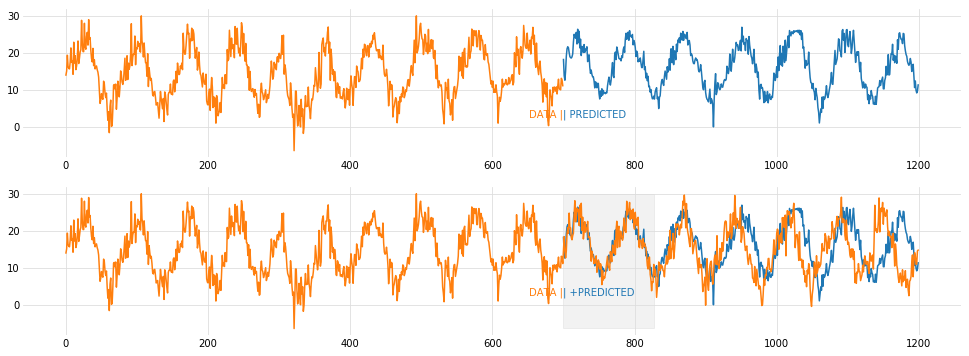

RMSE on 128 predictions (shaded area): 2.655464737996466


In [11]:
PRIMELEN=700
RUNLEN=500
OFFSET=430

prime_data = data[OFFSET:OFFSET+PRIMELEN]

results = prediction_run(prime_data, RUNLEN)

disp_data = data[OFFSET:OFFSET+PRIMELEN+RUNLEN]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(211)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| PREDICTED", color=colors[0], horizontalalignment="left")
displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN]), results)))
displayresults = np.ma.masked_where(displayresults == 0, displayresults)
plt.plot(displayresults)
displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN]))))
displaydata = np.ma.masked_where(displaydata == 0, displaydata)
plt.plot(displaydata)
plt.subplot(212)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| +PREDICTED", color=colors[0], horizontalalignment="left")
plt.plot(displayresults)
plt.plot(disp_data)
RMSELEN=128
plt.axvspan(PRIMELEN, PRIMELEN+RMSELEN, color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
plt.show()

rmse = math.sqrt(np.mean((data[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.